# TfIdf Vectorization of a large corpus
Usually Tfidf vectors need to be trained on a domain-specific corpus. However, in many cases, a generic baseline of idf values can be good enough, and helpful for computing generic tasks like weighting sentence embeddings. Besides the obvious memory challenges with processing a large corpus, there are important questions that need to be resolved when organizing a collection of documents:

* What is considered a document?
    * is one epistle one document?
    * is one section or chapter of one speech one document?
    * is one poem a one document? ranging from epigram to a book of epic poetry?
    * is one chapter in a prose book one document?
    * Disagree with any of these? then you'll want to train your own word idf mapping and compare results.
* How can we compare TfIdf vectors, what are some simple baselines?

In this notebook we'll work towards creating a generic tfidf vector for a discrete but general purpose corpus.
Of course, any time you can limit the scope of your documents to a particular domain and train on those, then you will get better results, but to handle unseen data in a robust manner, a general idf mapping is better than assuming a uniform distribution!

We'll look at the Tessearae corpus, and generate a word : idf mapping that we can use elsewhere for computing sentence embeddings.

We'll generate and assess tfidf vectors of the Tesserae corpus broken into (by turns):
* 762 files
* 49,938 docs

In [1]:
import os
import pickle
import re
import sys
from collections import Counter, defaultdict
from glob import glob
from pathlib import Path
currentdir = Path.cwd()
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)
from tqdm import tqdm
from cltk.alphabet.lat import normalize_lat
from cltk.sentence.lat import LatinPunktSentenceTokenizer
from cltk.tokenizers.lat.lat import LatinWordTokenizer
from mlyoucanuse.text_cleaners import swallow
from scipy.spatial.distance import cosine
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt

In [2]:
tesserae = glob(os.path.expanduser('~/cltk_data/latin/text/latin_text_tesserae/texts/*.tess'))
print(f"Tesserae corpus contains: {len(tesserae)} files")

Tesserae corpus contains: 762 files


# Conversions and helper functions

In [3]:
ANY_ANGLE = re.compile("<.[^>]+>") # used to remove tesserae metadata 

toker = LatinWordTokenizer()
sent_toker = LatinPunktSentenceTokenizer()

def toker_call(text):
    # skip blank lines
    if text.strip() is None:
        return []
    text = swallow(text, ANY_ANGLE)        
    # normalize effectively reduces our corpus diversity by 0.028%
    text = normalize_lat(text, drop_accents=True, 
                         drop_macrons=True,
                         jv_replacement=True,
                         ligature_replacement=True)
    return toker.tokenize(text)

In [4]:
vectorizer = TfidfVectorizer(input='filename', tokenizer=toker_call) 
vectorizer.fit(tesserae)
print(f"size of vocab: {len(vectorizer.vocabulary_):,}")
word_idf_files = {key: vectorizer.idf_[idx] 
            for key,idx in tqdm(vectorizer.vocabulary_.items(), total=len(vectorizer.idf_))}
del vectorizer

/Users/todd/opt/anaconda3/envs/mlycu3.8/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
  0%|          | 65/299456 [00:00<07:44, 644.12it/s]

size of vocab: 299,456


100%|██████████| 299456/299456 [06:36<00:00, 754.70it/s]


# Corpus to Documents functions

In [5]:
def count_numbers(text):
    """
    Count the numbers groups in a line of text
    
    >>> count_numbers ('<caes. gal. 8.0.4>')
    3
    >>> count_numbers('<caes. gal. 1.10.1>')
    3
    >>> count_numbers("<ov. her. 1.116>        Protinus")
    2
    >>> count_numbers("<cic. arch. 1> si quid est in me ingeni")
    1
    """
    if re.search(r'\d+\.\d+\.\d+', text):
        return 3
    if re.search(r'\d+\.\d+', text):
        return 2
    if re.search(r'\d+', text):
        return 1
    return 0


def make_file_docs(filename):
    """given a filename return a dictionary with a list of docs.
    
    if two numbers found, join on the first one 
    <verg. aen. 9.10>	Nec satis: extremas Corythi penetravit ad urbes
    <verg. ecl. 1.2> silvestrem tenui Musam meditaris avena;

    if 3 numbers found, create a doc for each cluster of the first two numbers
    <livy. urbe. 31.1.3> tot enim sunt a primo Punico ad secundum bellum finitum—
    if just one number split on that
    "<cic. arch. 1> si quid est in me ingeni"
    
    """
    file_docs =defaultdict(list)
    file_stats = {}
    file = os.path.basename(filename)
    ibook = None
    ichapter = None
    with open(filename, 'rt') as fin:
        prev_ch= None
        lines =[]
        all_text=""
        for line in fin:
            numbers_found = count_numbers(line)
            if numbers_found == 0:
                if line.strip():
                    text = swallow(line, ANY_ANGLE)     
                    file_docs[f"{file}"].append(text)
                continue
            if numbers_found == 3:
                match = re.search(r'\d+\.\d+\.\d+', line) 
                if not match:
                    continue
                start, end = match.span()
                num_section = line[start:end]
                book, chapter, sent = num_section.split(".")
                ibook = int(book)
                ichapter = int(chapter)
                text = swallow(line, ANY_ANGLE)     
                if prev_ch == None:
                    lines.append(text)
                    prev_ch = ichapter
                    continue
                if prev_ch != ichapter:
                    file_docs[f"{file}.{ibook}.{prev_ch}"].extend(lines)
                    lines = []
                    lines.append(text)
                    prev_ch = ichapter
                else:
                    lines.append(text)                
            if numbers_found ==2:
                if line.strip():
                    match = re.search(r'\d+\.\d+', line) 
                    if not match:
                        continue
                    start, end = match.span()                                      
                    num_section = line[start:end]
                    book, chapter = num_section.split(".")
                    ibook = int(book)
                    ichapter = int(chapter)
                    text = swallow(line, ANY_ANGLE)     
                    file_docs[f"{file}.{ibook}"].append(text)
                continue                                    
            if numbers_found ==1:
                if line.strip():
                    match = re.search(r'\d+', line) 
                    start, end = match.span()                                      
                    num_section = line[start:end]
                    ibook = int(num_section)
                    text = swallow(line, ANY_ANGLE)     
                    file_docs[f"{file}.{ibook}"].append(text)
                continue                                                                    
    if ibook and ichapter and lines:
        all_text = ' '.join(lines)
        file_docs[f"{file}.{ibook}.{ichapter}"].append(all_text)
        prev_ch = None
    return file_docs

def make_docs(files):
    docs = []
    for file in files:
        try:
            file_docs = make_file_docs(  file )
            for key in file_docs:
                docs.append(' '.join(file_docs[key]))
        except Exception as ex:
            print("fail with", file)
            raise(ex)
    return docs

## Tests of corpus processing

In [7]:
base = os.path.expanduser("~/cltk_data/latin/text/latin_text_tesserae/texts/")
file_docs = make_file_docs(f"{base}caesar.de_bello_gallico.part.1.tess")
assert(len(file_docs)==54)
file_docs = make_file_docs(f"{base}vergil.eclogues.tess")
assert(len(file_docs)==10)
file_docs = make_file_docs(f"{base}ovid.fasti.part.1.tess")
assert(len(file_docs)==1)
# print(len(file_docs))
# file_docs 

test_files = [ f"{base}caesar.de_bello_gallico.part.1.tess" ,
              f"{base}vergil.eclogues.tess",
              f"{base}ovid.fasti.part.1.tess"] 
docs = make_docs(test_files)
assert(len(docs)==65)

In [10]:
docs = make_docs(tesserae)
print(f"{len(tesserae)} corpus files broken up into {len(docs):,} documents") 

vectorizer = TfidfVectorizer(tokenizer=toker_call) 
vectorizer.fit(docs)
word_idf = {key: vectorizer.idf_[idx] 
            for key,idx in tqdm(vectorizer.vocabulary_.items(), total=len(vectorizer.idf_))}
del vectorizer
print(f"distinct words {len(word_idf):,}")

762 corpus files broken up into 49,938 documents


100%|██████████| 299406/299406 [06:29<00:00, 768.23it/s]

distinct words 299,406


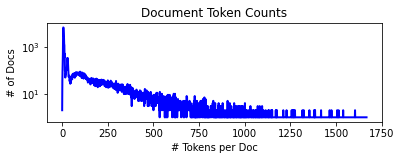

In [11]:
token_lengths = [len(tmp.split()) for tmp in docs]
counter = Counter(token_lengths)
indices_counts = list(counter.items())
indices_counts.sort(key=lambda x:x[0])
indices, counts = zip(*indices_counts )
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
line, = ax.plot(counts, color='blue', lw=2)
ax.set_yscale('log')
plt.title("Document Token Counts")
plt.xlabel("# Tokens per Doc")
plt.ylabel("# of Docs")
plt.show()

## This word : idf mapping we'll save for sentence vectorization

In [12]:
latin_idf_dict_file = "word_idf.latin.pkl"
with open(latin_idf_dict_file, 'wb') as fout:
    pickle.dump(word_idf, fout)

## Compare the idf values using Mean Square Error, Cosine
These values become more meaningful as the ETL processes are changed; the measurements may well indicate how much value have shifted.

In [20]:
words_idfs = list(word_idf.items())
words_idfs.sort(key=lambda x: x[0])
words_idf_files = list(word_idf_files.items())
words_idf_files.sort(key=lambda x: x[0])
print(f"Words Idfs vocab size: {len(words_idfs):,}, Words Idf from files {len(words_idf_files):,}") 
words_idfs = [(key, word_idf.get(key)) for key,val in words_idfs
              if key in word_idf_files]
words_idf_files = [(key, word_idf_files.get(key)) for key,val in words_idf_files 
                  if key in word_idf]
assert( len(words_idfs) == len(words_idf_files))
print(f"Total # shared vocab: {len(words_idfs):,}")
_, idfs = zip(*words_idfs)
_, idfs2 = zip(*words_idf_files)
print(f"MSE: {mse(idfs, idfs2)}")
print(f"Cosine: {cosine(idfs, idfs2)}")

Words Idfs vocab size: 299,406, Words Idf from files 299,456
Total # shared vocab: 299,387
MSE: 16.972181321245785
Cosine: 0.0015073304069079807
